<img src = https://learnopencv.com/wp-content/uploads/2024/09/Feature-Multimodal-RAG-with-ColPali-Gemini.gif>

# ColPali: Efficient Document Retrieval with Vision Language Models 📃 

[![arXiv](https://img.shields.io/badge/arXiv-2407.01449-b31b1b.svg?style=for-the-badge)](https://arxiv.org/abs/2407.01449)



In [1]:
!pip install colpali-engine==0.2.2 -q
!pip install -U bitsandbytes -q
!pip install mteb transformers tqdm typer seaborn -q
!pip install pdf2image einops google-generativeai gradio -q

### **Restart Session ↻**

In [16]:
# %%bash

# sudo apt-get install poppler-utils

In [5]:
# PaliGemma is a gated repo, therefore HF Token is necessary
# Visit PaliGemma model card and agree terms to conditions to get access

!huggingface-cli login --token 

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [1]:
import torch
import typer
from tqdm import tqdm
from transformers import AutoProcessor, BitsAndBytesConfig, AutoModelForCausalLM
import getpass

from PIL import Image
import numpy as np
import glob
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pdf2image import convert_from_path
from typing import List, Union, Tuple, cast
from dataclasses import asdict
from pathlib import Path
from einops import rearrange
import os 
import requests 

from colpali_engine.models.paligemma_colbert_architecture import ColPali
from colpali_engine.trainer.retrieval_evaluator import CustomEvaluator
from colpali_engine.utils.colpali_processing_utils import process_images, process_queries
from colpali_engine.utils.image_from_page_utils import load_from_dataset

from colpali_engine.interpretability.vit_configs import VIT_CONFIG

from colpali_engine.interpretability.plot_utils import plot_attention_heatmap

from colpali_engine.interpretability.gen_interpretability_plots import generate_interpretability_plots
from colpali_engine.interpretability.processor import ColPaliProcessor
from colpali_engine.interpretability.plot_utils import plot_attention_heatmap
from colpali_engine.interpretability.torch_utils import normalize_attention_map_per_query_token


# Set the API key in the environment variable
# Prompt for the API key securely
gemini_api_key = getpass.getpass(prompt="Enter your GEMINI API key: ")

# Set the API key in the environment variable
os.environ["GEMINI_API_KEY"] = gemini_api_key

## ColPali

In [2]:
model_name = "vidore/colpali" # specify the adapter model name

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    # bnb_4bit_compute_dtype=torch.bfloat16
)



retrieval_model = ColPali.from_pretrained("google/paligemma-3b-mix-448",
                                          torch_dtype=torch.float16, # set the dtype to bfloat16
                                          device_map="cuda",quantization_config=bnb_config).eval()    # set the device to cuda

vit_config = VIT_CONFIG["google/paligemma-3b-mix-448"]

retrieval_model.load_adapter(model_name)
paligemma_processor = AutoProcessor.from_pretrained(model_name)
device = retrieval_model.device

/opt/conda/lib/python3.11/site-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of ColPali were not initialized from the model checkpoint at google/paligemma-3b-mix-448 and are newly initialized: ['custom_text_proj.bias', 'custom_text_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
print(retrieval_model)

ColPali(
  (model): PaliGemmaForConditionalGeneration(
    (vision_tower): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(1024, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-26): 27 x SiglipEncoderLayer(
              (self_attn): SiglipSdpaAttention(
                (k_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                (v_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                (q_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                (out_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
              )
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (mlp): SiglipMLP(
                (

## Indexing

In [4]:
# Function to index the PDF document (Get the embedding of each page)
def index(files: List[str]) -> Tuple[str, List[torch.Tensor], List[Image.Image]]:
    images = []
    document_embeddings = []

    # Convert PDF pages to images
    for file in files:
        print(f"Indexing now: {file}")
        images.extend(convert_from_path(file))
        

    # Create DataLoader for image batches
    dataloader = DataLoader(
        images,
        batch_size=1,
        shuffle=False,
        collate_fn=lambda x: process_images(paligemma_processor, x),
    )

    # Process each batch and obtain embeddings
    for batch in dataloader:
        with torch.no_grad():
            batch = {key: value.to(device) for key, value in batch.items()}
            embeddings = retrieval_model(**batch)
        document_embeddings.extend(list(torch.unbind(embeddings.to("cpu"))))
    total_memory = sum(embedding.element_size() * embedding.nelement() for embedding in document_embeddings)
    print(f'Total Embedding Memory (CPU): {total_memory/1024 **2} MB')


    total_image_memory = sum(image.width * image.height * 3 for image in images)  # 3 for RGB channels
    print(f'Total Image Memory: {total_image_memory / (1024 ** 2)} MB')
        

    # Return document embeddings, and images
    return document_embeddings, images

## Download fincancial statements pdf

In [5]:
DATA_FOLDER = "data"
os.makedirs(DATA_FOLDER,exist_ok = True)

!wget -nc https://www.apple.com/newsroom/pdfs/fy2024-q1/FY24_Q1_Consolidated_Financial_Statements.pdf -O "data/apple-2024.pdf" -q
!wget -nc https://abc.xyz/assets/9c/12/c198d05b4f7aba1e9487ba1c8b79/goog-10-q-q1-2024.pdf -O "data/google-alphabet-2024.pdf" -q
!wget -nc https://digitalassets.tesla.com/tesla-contents/image/upload/IR/TSLA-Q4-2023-Update.pdf -O "data/tesla-2023-q4.pdf" -q
!wget -nc https://s201.q4cdn.com/141608511/files/doc_financials/2024/q1/ecefb2b2-efcb-45f3-b72b-212d90fcd873.pdf -O "data/nvidia-2024-q1.pdf" -q

## Start Indexing...

In [6]:
pdf_files = [os.path.join(DATA_FOLDER, file) for file in os.listdir(DATA_FOLDER) if file.lower().endswith('.pdf')]
document_embeddings, images = index(pdf_files)

Indexing now: data/apple-2024.pdf
Indexing now: data/google-alphabet-2024.pdf
Indexing now: data/tesla-2023-q4.pdf
Indexing now: data/nvidia-2024-q1.pdf


/opt/conda/lib/python3.11/site-packages/bitsandbytes/nn/modules.py:435: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Total Embedding Memory (CPU): 32.6904296875 MB
Total Image Memory: 2044.7755737304688 MB


In [7]:
document_embeddings[1]

tensor([[ 0.0925, -0.0371, -0.0560,  ...,  0.0432,  0.0218, -0.0851],
        [ 0.0457,  0.0680, -0.0265,  ..., -0.0273, -0.0433,  0.0028],
        [ 0.0762,  0.0210, -0.0388,  ...,  0.0126, -0.0155, -0.0075],
        ...,
        [ 0.0103,  0.0429, -0.0141,  ...,  0.0600, -0.0313,  0.1091],
        [ 0.0516,  0.0355, -0.0565,  ...,  0.0646, -0.0217,  0.0338],
        [ 0.0725,  0.0192, -0.0897,  ...,  0.0072, -0.0021, -0.0371]],
       dtype=torch.float16)

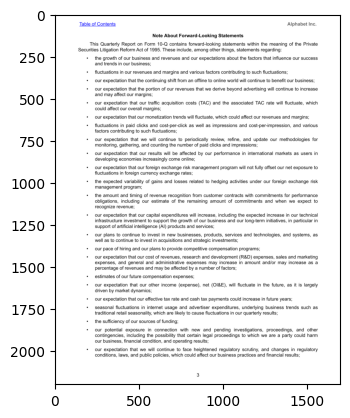

In [8]:
#Sanity Check
plt.imshow(images[5])

## Document Retrieval with ColPali

In [9]:
def retrieve_top_document(query: str, document_embeddings: List[torch.Tensor], document_images: List[Image.Image]) -> Tuple[str, Image.Image]:
    query_embeddings = []
    # Create a placeholder image
    placeholder_image = Image.new("RGB", (448, 448), (255, 255, 255))

    with torch.no_grad():
        # Process the query to obtain embeddings
        query_batch = process_queries(paligemma_processor, [query], placeholder_image)
        query_batch = {key: value.to(device) for key, value in query_batch.items()}
        query_embeddings_tensor = retrieval_model(**query_batch)
        query_embeddings = list(torch.unbind(query_embeddings_tensor.to("cpu")))

    # Evaluate the embeddings to find the most relevant document
    evaluator = CustomEvaluator(is_multi_vector=True)
    similarity_scores = evaluator.evaluate(query_embeddings, document_embeddings)

    # Identify the index of the highest scoring document
    best_index = int(similarity_scores.argmax(axis=1).item())

    # Return the best matching document text and image
    return document_images[best_index], best_index

## LLM

In [10]:
from PIL import Image 
import requests 
from transformers import AutoModelForCausalLM 
from transformers import AutoProcessor 

model_id = "microsoft/Phi-3.5-vision-instruct" 

model = AutoModelForCausalLM.from_pretrained(model_id, device_map="cuda", trust_remote_code=True, torch_dtype="auto", _attn_implementation='eager',quantization_config = bnb_config) # use _attn_implementation='eager' to disable flash attention

processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True) 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/transformers/models/auto/image_processing_auto.py:513: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [11]:
def phi_vision(search_query:str , image:Image):
    
    messages = [ 
    {
        "role": "user", 
        "content": '<|image_1|>\nWhat is shown in this image? Explain me in brief about the' + search_query
    }
    ]

    prompt = processor.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    
    inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0") 
    
    generation_args = { 
        "max_new_tokens": 1024, 
        "temperature": 0.0, 
        "do_sample": False, 
    } 

    generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)
    
    # remove input tokens 
    generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
    
    response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0] 
    
    print(response)

## Gemini LLM

In [16]:
import google.generativeai as genai

generation_config = {
  "temperature": 0.0,
  "top_p": 0.95,
  "top_k": 64,
  "max_output_tokens": 1024,
  "response_mime_type": "text/plain",
}

genai.configure(api_key=gemini_api_key)

model = genai.GenerativeModel(model_name="gemini-1.5-flash" , generation_config=generation_config)

def get_answer(prompt:str , image:Image):
  response = model.generate_content([prompt, image])
  return response.text
    
model

genai.GenerativeModel(
    model_name='models/gemini-1.5-flash',
    generation_config={'temperature': 0.0, 'top_p': 0.95, 'top_k': 64, 'max_output_tokens': 1024, 'response_mime_type': 'text/plain'},
    safety_settings={},
    tools=None,
    system_instruction=None,
    cached_content=None
)

In [17]:
def answer_query(query: str ,prompt):
    # Retrieve the most relevant document based on the query
    best_image, best_index = retrieve_top_document(query=query, 
                                        document_embeddings=document_embeddings, 
                                        document_images=images)

    # Generate an answer using the retrieved document 
    
    # answer = phi_vision(prompt, best_image)

    #Gemini 1.5 Flash
    answer = f"Gemini Response\n: {get_answer(prompt, best_image)}"
    

    return answer, best_image, best_index

## Perform Multimodal RAG

tensor([7])
Top 1 Accuracy (verif): 0.0
The image shows the consolidated balance sheets of Alphabet Inc. for the periods ending December 31, 2023, and March 31, 2024. The balance sheet is divided into three sections: assets, liabilities, and stockholders' equity. The assets section includes current assets, non-current assets, and total assets. The liabilities section includes current liabilities, long-term debt, and total liabilities. The stockholders' equity section includes preferred stock, common stock, accumulated other comprehensive income (loss), retained earnings, and total stockholders' equity. The balance sheet shows that Alphabet Inc. had total assets of $402,392 million as of December 31, 2023, and $407,350 million as of March 31, 2024. The company had total liabilities of $119,013 million as of December 31, 2023, and $114,506 million as of March 31, 2024. The company had total stockholders' equity of $283,379 million as of December 31, 2023, and $292,844 million as of March

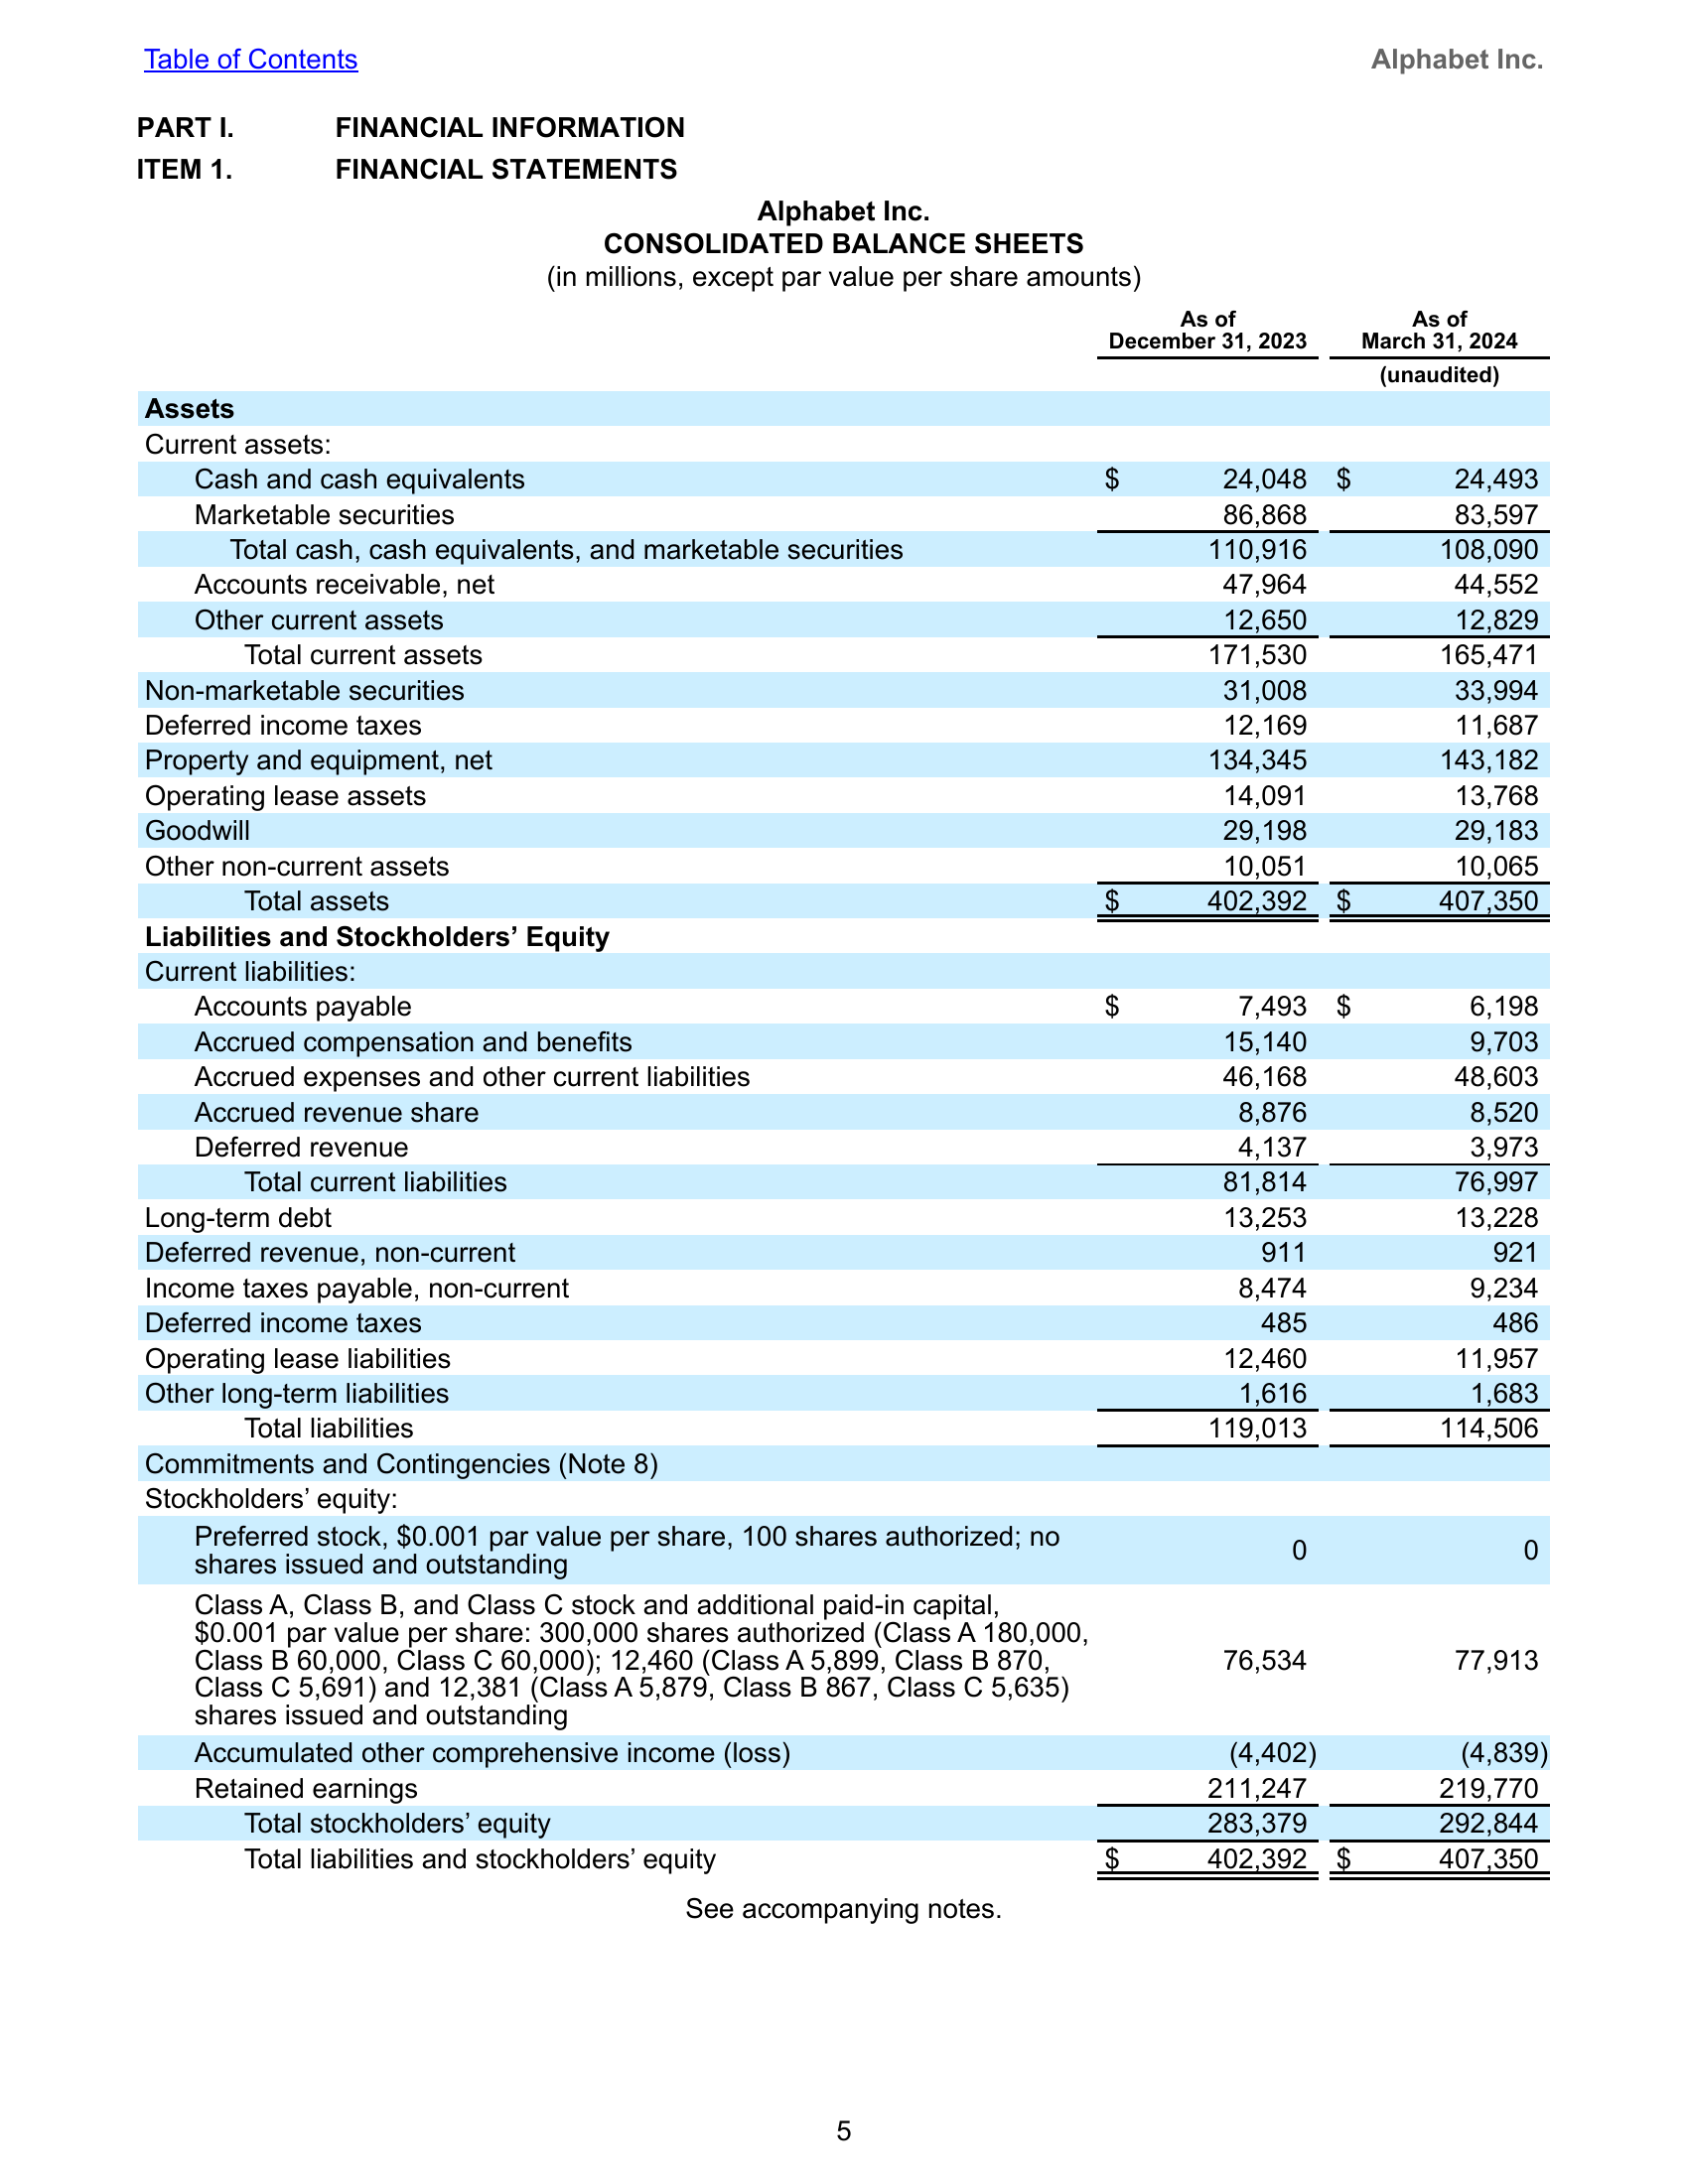

In [25]:
search_query = "Alphabet Inc. Balance Sheets"
prompt = "What is shown in this imageOnline Querying, explain it? Format the answer in neat 200 words summary" 
answer, best_image,best_index  = answer_query(search_query, prompt)
retrieved_idx = best_index

print(answer)

best_image

## Visualize Heatmaps for Search Query

Image size:  (1700, 2200)
 Tokens Idx:  {0: 'Alphabet', 1: '▁Inc', 2: '.', 3: '▁Balance', 4: '▁Sheets'}
Attention Token Chosen: [' Balance']


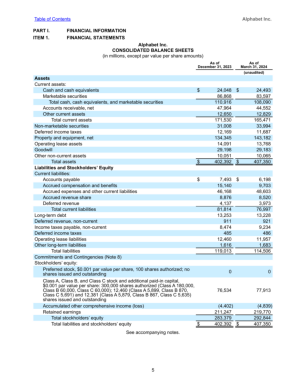

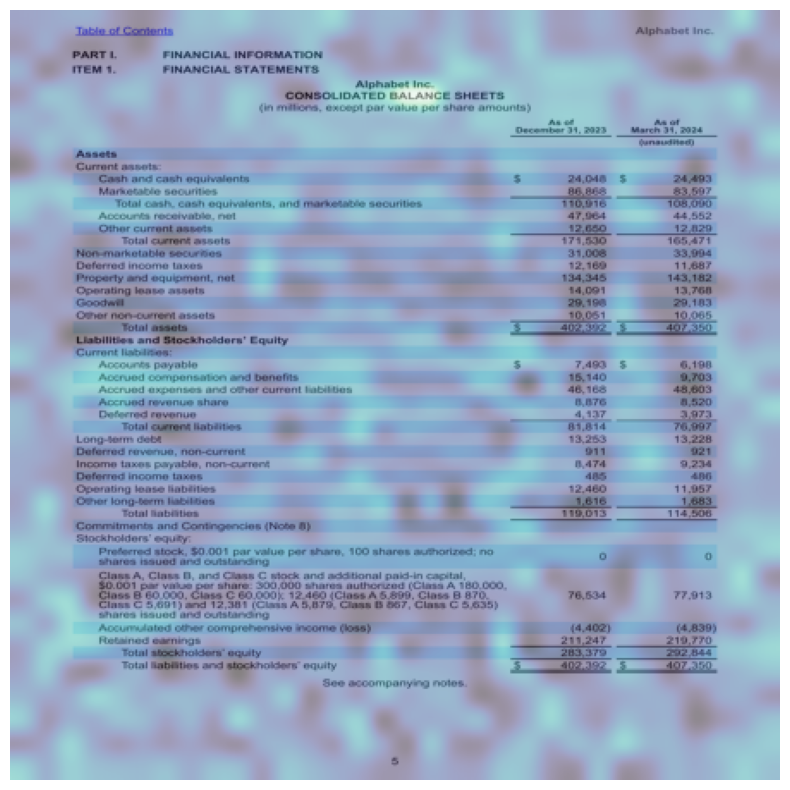

In [29]:
retrieved_image = images[retrieved_idx]

colpali_processor = ColPaliProcessor(paligemma_processor)

# Resize the image to square
input_image_square = retrieved_image.resize((vit_config.resolution, vit_config.resolution))

# scale_image(image, 256)

plt.imshow(retrieved_image)
plt.axis('off')

print("Image size: ",retrieved_image.size)

input_text_processed = colpali_processor.process_text(search_query).to(device)
input_image_processed = colpali_processor.process_image(retrieved_image, add_special_prompt=True).to(device)

with torch.no_grad():
    output_text = retrieval_model.forward(**asdict(input_text_processed))  # type: ignore

with torch.no_grad():
    output_image = retrieval_model.forward(**asdict(input_image_processed))  # type: ignore

# Remove the memory tokens
output_image = output_image[:, : colpali_processor.processor.image_seq_length, :]  # (1, n_patch_x * n_patch_y, hidden_dim)

output_image = rearrange(
    output_image, "b (h w) c -> b h w c", h=vit_config.n_patch_per_dim, w=vit_config.n_patch_per_dim
)

attention_map = torch.einsum("bnk,bijk->bnij", output_text, output_image)

# Normalize the attention map (all values should be between 0 and 1)
attention_map_normalized = normalize_attention_map_per_query_token(attention_map)

# attention_map_normalized.shape

# Use this cell output to choose a token"
idx = {idx: val for idx, val in enumerate(colpali_processor.tokenizer.tokenize(search_query))}
print(" Tokens Idx: ", idx)

token_idx = len(idx) - 1
print(f"Attention Token Chosen: {colpali_processor.batch_decode(input_text_processed.input_ids[:, token_idx])}")

attention_map_image = Image.fromarray(
    (attention_map_normalized[0, token_idx, :, :].cpu().numpy() * 255).astype("uint8")
).resize(input_image_square.size, Image.Resampling.BICUBIC) 
fig, ax = plot_attention_heatmap(
    input_image_square,
    patch_size=vit_config.patch_size,
    image_resolution=vit_config.resolution,
    attention_map=attention_map_normalized[0,token_idx, : ,:],
)

os.makedirs("activations",exist_ok = True)

fig.savefig("activations/heatmap")


In [42]:
search_query = "Apple Inc. Balance Sheets"
answer, best_image,best_index  = answer_query(search_query, prompt)
retrieved_idx = best_index


generate_interpretability_plots(model = retrieval_model,processor = colpali_processor, query = search_query,image = best_image, savedir = "activations/", add_special_prompt_to_doc = False)
# Whether to save attention map of special token attention (not required)

tensor([1])
Top 1 Accuracy (verif): 0.0
Text tokens:
['<bos>', 'Apple', '▁Inc', '.', '▁Balance', '▁Sheets', '\n']




Iterating over tokens...:  20%|██        | 1/5 [00:15<01:00, 15.24s/it]

Saved attention map for token 1 (`Apple`) to `activations/token_1.png`.



Iterating over tokens...:  40%|████      | 2/5 [00:25<00:37, 12.50s/it]

Saved attention map for token 2 (`▁Inc`) to `activations/token_2.png`.



Iterating over tokens...:  60%|██████    | 3/5 [00:37<00:24, 12.31s/it]

Saved attention map for token 3 (`.`) to `activations/token_3.png`.



Iterating over tokens...:  80%|████████  | 4/5 [00:48<00:11, 11.76s/it]

Saved attention map for token 4 (`▁Balance`) to `activations/token_4.png`.



Iterating over tokens...: 100%|██████████| 5/5 [01:00<00:00, 12.09s/it]

Saved attention map for token 5 (`▁Sheets`) to `activations/token_5.png`.



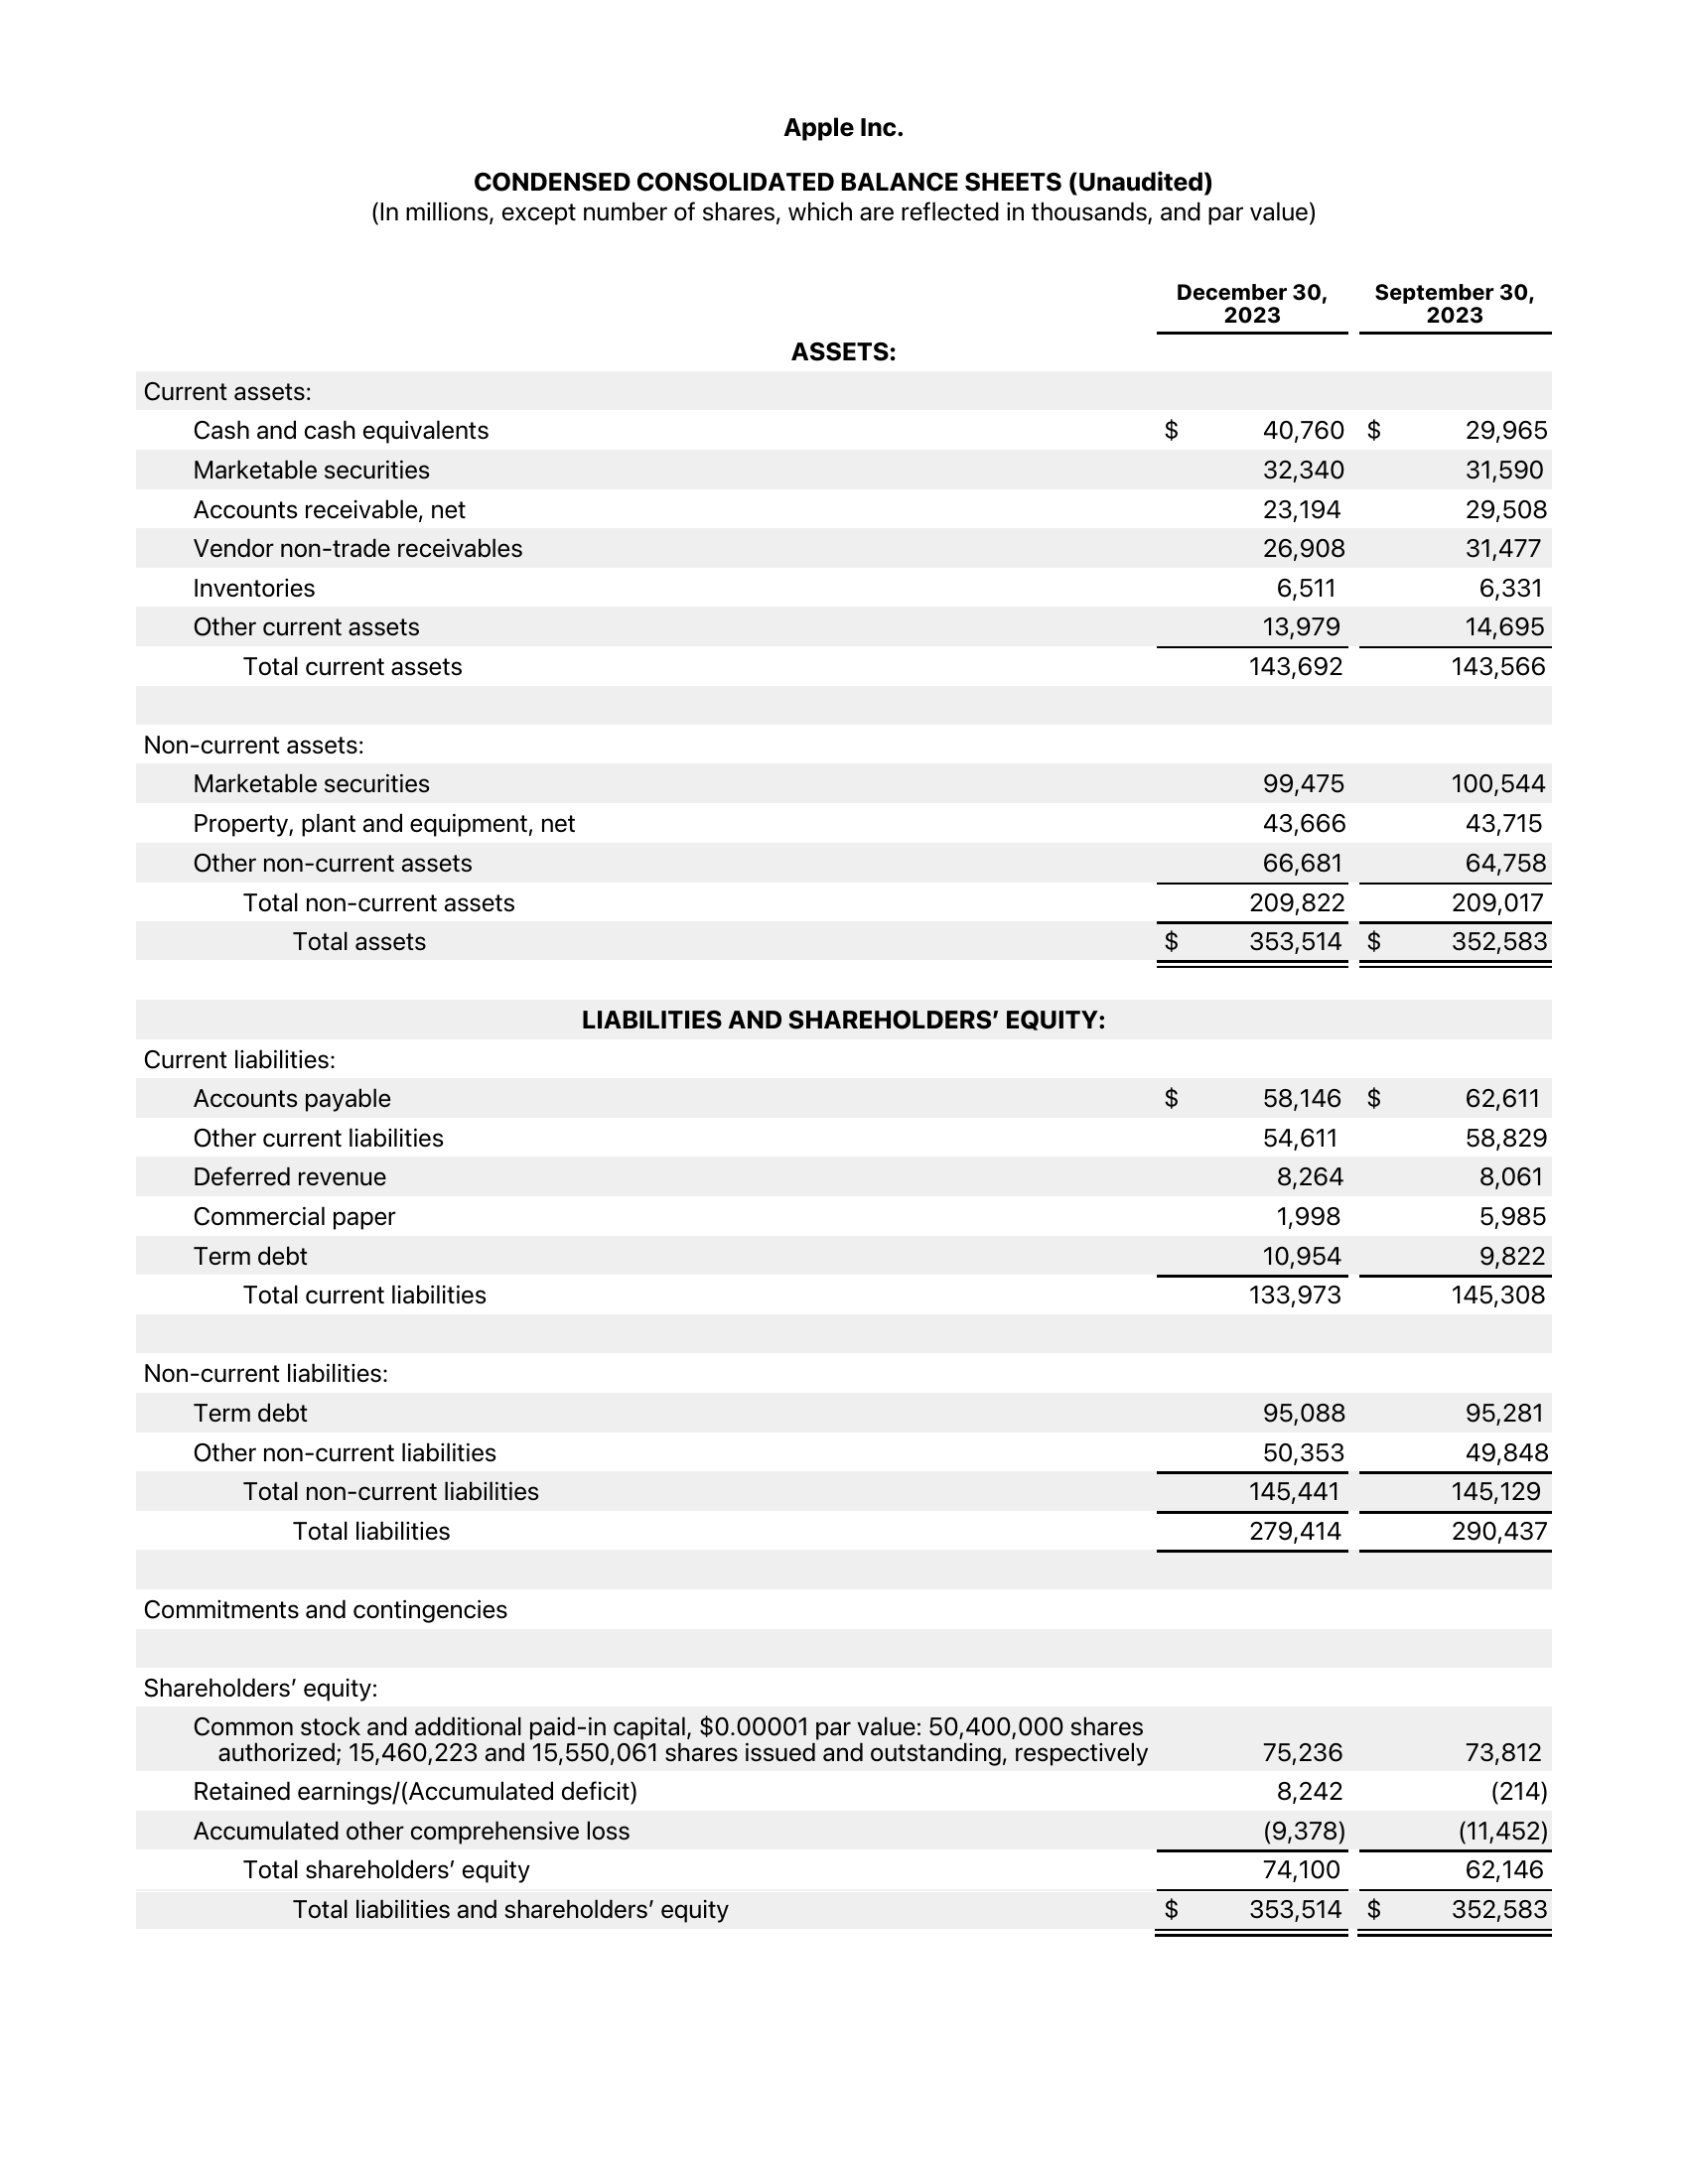

In [43]:
best_image

## Patch activations - Overlayed

In [44]:
def overlay_attention_map(image, attention_map_path: str, output_path: str, alpha: float = 0.4):
    # Load the image and the attention map
    # image = Image.open(image_path).convert("RGB")
    # image_sz = image.shape
    image = image.resize((800,800))
    attention_map = Image.open(attention_map_path).convert("L")  # Convert attention map to grayscale

    # Resize the attention map to match the image size
    attention_map = attention_map.resize(image.size, resample=Image.BILINEAR)

    # Convert the attention map to a numpy array and normalize it
    attention_map_np = np.array(attention_map) / 255.0

    # Create a color map (e.g., a heatmap) for the attention map
    colormap = plt.get_cmap("jet")
    attention_map_colored = colormap(attention_map_np)  # Apply colormap
    attention_map_colored = np.uint8(attention_map_colored * 255)  # Convert to uint8 type
    attention_map_colored = Image.fromarray(attention_map_colored[..., :3])  # Drop the alpha channel

    # Overlay the attention map on the image
    overlay = Image.blend(image, attention_map_colored, alpha=alpha)

    # plt.imshow(overlay)
    plt.axis('off')

    # Save and show the result
    overlay.save(output_path)
    overlay.show()

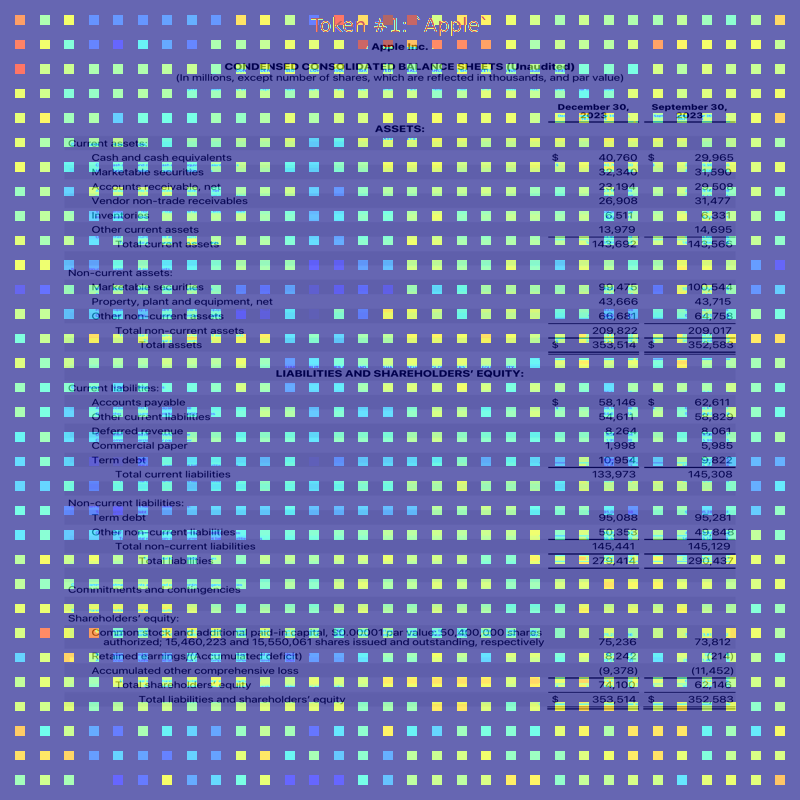

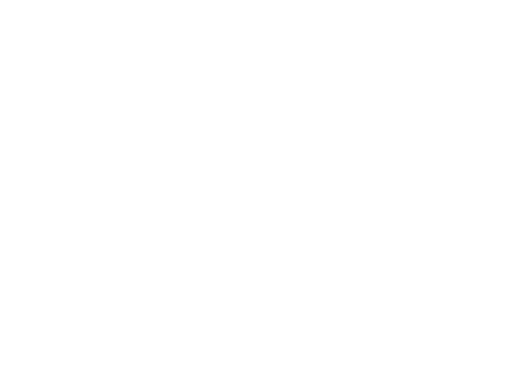

In [45]:
attention_map_path = "activations/token_1.png"

output_path = "/overlay_token1.png"

overlay_attention_map(best_image, attention_map_path, output_path, alpha=0.6)

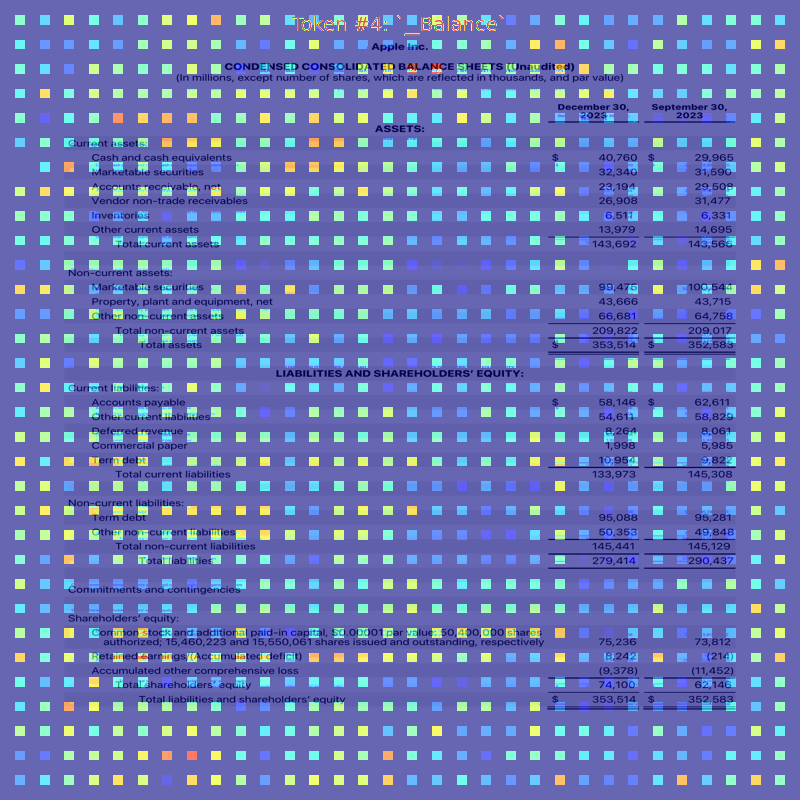

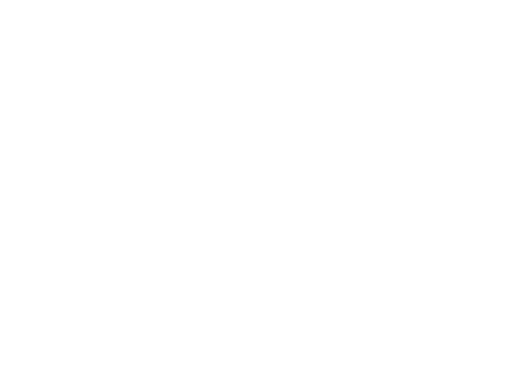

In [48]:
attention_map_path = "activations/token_4.png"
output_path = "/overlay_token4.png"

overlay_attention_map(best_image, attention_map_path, output_path, alpha=0.6)


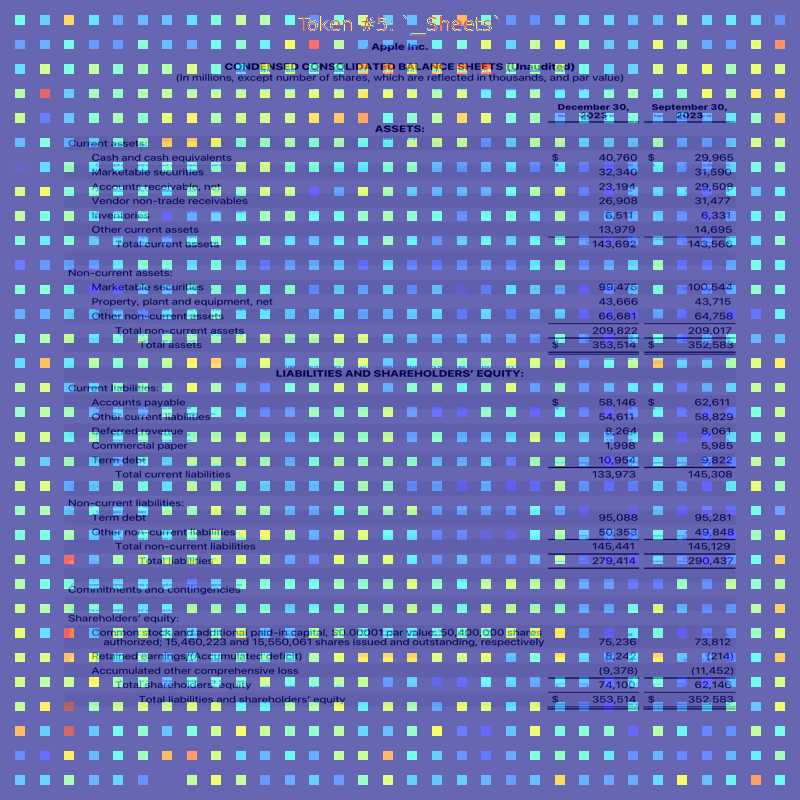

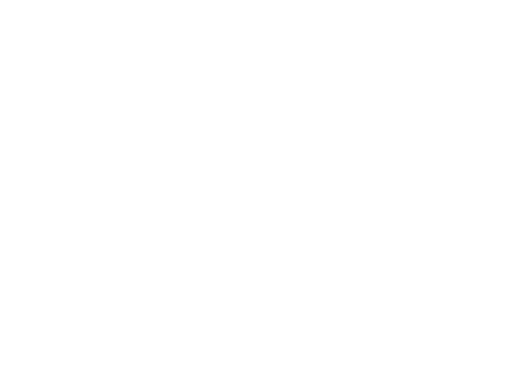

In [49]:
attention_map_path = "activations/token_5.png"
output_path = "/overlay_token5.png"

overlay_attention_map(best_image, attention_map_path, output_path, alpha=0.6)